# Latent dimensions: The most powerful analysis nobody does

Take a thousand people and measure their height, weight, arms, legs, hands, feet, etc. Now ask yourself the question, *"Could I be measuring a single thing from many angles?"*

In a sense, yes: You're measuring a person's **size** in different ways. Sure, there are other things you're measuring, but size is the main thing.

Wouldn't it be great to go from a table like this:

| height (cm) | weight (kg) | arm length (cm) | leg length (cm) | hand length (cm) | foot length (cm) | ... |
|-------------|-------------|-----------------|-----------------|------------------|------------------|-----|
| 170         | 70          | 60              | 90              | 18               | 25               | ... |
| 180         | 80          | 65              | 95              | 19               | 26               | ... |
| ...         | ...          | ...              | ...              | ...               | ...               | ... |

...to a table like this?

| human size | major thing 2 | major thing 3 | ... |
|-------------|-------------|-----------------|-----------------|
| -1.5         | 0.632      | 0.16              | ...              |
| 3.74         | -0.92      | 0.01              | ...            |
| ...         | ...         | ...              | ...            |


This notebook is about just that: figuring out the main things. The algorithm will find them, and we must interpret them. If the code doesn't make sense, just skim through it to find my notes, which will explain what is going on.

We've created a set of 800+ company metrics (features), much of which must be redundant. We'll use a [simple technique](https://en.wikipedia.org/wiki/Principal_component_analysis) to extract and study a few [latent variables](https://en.wikipedia.org/wiki/Latent_space) from the features. Those are our "main things".

In doing so, we'll use the data in a new way: *to teach us*. It is common to use machine learning for prediction. It rare to use ML to *figure out what has happened and what it means*.

---

Disclaimer: I am not an investment professional. None of my work within or related to this notebook should be considered investment advice. It is not.

# Setup

In [1]:
import duckdb
import os
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from xgboost import XGBRegressor
import ipywidgets as widgets

data_path = Path(os.getenv('DATA_HOME'))
demo_data_path = data_path.joinpath('analytics_demo')
duckdb_path = demo_data_path.joinpath('sharadar.duckdb')

In [2]:
con = duckdb.connect(str(duckdb_path))
df_mcap_reg = con.execute('from mcap_reg').fetch_df()
# Note: Now filtering out smallest 10% mcap and non-domestic.
df_fct_daily_targ = con.execute('from fct_daily_targ where mcap_perc_rank < .9').fetch_df()
df_tickers = con.execute("from lookup_tickers_keep").fetch_df()
list_domestic_tickers = df_tickers.ticker.drop_duplicates().tolist()
df_fct_daily_targ = df_fct_daily_targ[df_fct_daily_targ.ticker.isin(list_domestic_tickers)].copy()
con.close()

df = df_fct_daily_targ[['key_daily', 'ticker', 'excess_price_chg_1y']].merge(df_mcap_reg, how='inner', on='key_daily')
df = df.rename(columns={'excess_price_chg_1y': 'epc'})
cols_meta = ['key_daily', 'ticker', 'date', 'mcap_daily_scaled_log', 'epc']
cols_feat = df.columns.drop(cols_meta).tolist()
print(df.shape)
df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(937793, 879)


,key_daily,ticker,epc,date,mcap_daily_scaled_log,accoci_art_scaled,assets_art_scaled,assetsavg_art_scaled,assetsc_art_scaled,assetsnc_art_scaled,...,liabilitiesc_over_fcf_art_chg,payables_over_assetsavg_art_chg,payables_over_revenue_art_chg,payables_over_fcf_art_chg,ncfx_over_assetsavg_art_chg,ncfx_over_revenue_art_chg,ncfx_over_fcf_art_chg,deferredrev_over_assetsavg_art_chg,deferredrev_over_revenue_art_chg,deferredrev_over_fcf_art_chg
0,TRVI_2023-04-05,TRVI,0.070,2023-04-05,8.340,0.059,0.000,0.000,0.000,0.000,...,-0.141,-0.012,NaN,-0.016,0.000,NaN,-0.000,0.000,NaN,-0.000
1,URZ_2010-04-06,URZ,0.333,2010-04-06,10.587,0.708,0.000,0.000,0.000,0.000,...,0.020,-0.051,NaN,0.061,-0.000,NaN,0.000,0.000,NaN,-0.000
2,CVS_2001-06-05,CVS,-0.308,2001-06-05,15.298,0.914,0.000,0.000,0.001,0.000,...,8.950,-0.055,-0.022,3.270,0.000,0.000,0.000,0.000,0.000,0.000
3,UIL_2005-10-05,UIL,0.032,2005-10-05,12.196,0.337,0.000,0.000,0.000,0.000,...,-42.707,0.001,-0.010,-14.664,0.000,0.000,-0.000,0.005,0.006,-4.008
4,IBM_2022-03-03,IBM,0.168,2022-03-03,15.245,0.046,0.000,0.000,0.001,0.001,...,0.228,-0.012,-0.004,-0.050,-0.001,-0.003,-0.016,-0.003,0.061,0.273


---

# Noticing Differences: Principal Component Analysis (PCA)

In our person-measuring example, PCA would provide an answer to the question, "In what ways do these people differ the most?" PCA would give you a few new "axes" along which the people differ. The *first principle component* (PC0) captures the way in which they differ most. Inspecting how that PC is constructed can reveal what it means.

We're now going to find out how companies differ from each other. We will start by finding out how many PCs are needed to capture most of the difference among companies. Then we'll try to interpret some of them!

In [3]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

In [4]:
df_pca = df[cols_meta].copy()

pca_pipeline = make_pipeline(SimpleImputer(), StandardScaler(), PCA())
pcs = pca_pipeline.fit_transform(df[cols_feat].replace([-np.inf, np.inf], np.nan))
# pca_pipeline = joblib.load(demo_data_path.joinpath('pca_pipeline.joblib'))
pcs = pca_pipeline.transform(df[cols_feat].replace([-np.inf, np.inf], np.nan))

cols_pc = ['pc{}'.format(x) for x in range(pcs.shape[1])]
df_pca = pd.concat([df_pca, pd.DataFrame(pcs, columns=cols_pc)], axis=1)
print(df_pca.shape)
df_pca.head()

(937793, 879)


,key_daily,ticker,date,mcap_daily_scaled_log,epc,pc0,pc1,pc2,pc3,pc4,...,pc864,pc865,pc866,pc867,pc868,pc869,pc870,pc871,pc872,pc873
0,TRVI_2023-04-05,TRVI,2023-04-05,8.340,0.070,0.011,-0.008,-0.058,0.474,-0.214,...,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,URZ_2010-04-06,URZ,2010-04-06,10.587,0.333,0.000,0.006,-0.058,0.388,0.359,...,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.002,-0.000,0.001,-0.001
2,CVS_2001-06-05,CVS,2001-06-05,15.298,-0.308,0.058,0.013,-0.047,-0.618,0.280,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000
3,UIL_2005-10-05,UIL,2005-10-05,12.196,0.032,0.075,-0.135,-0.097,-0.526,-0.321,...,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.001,0.000
4,IBM_2022-03-03,IBM,2022-03-03,15.245,0.168,0.053,0.004,-0.048,-0.422,-0.224,...,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.001,0.000


In [ ]:
# joblib.dump(pca_pipeline, demo_data_path.joinpath('pca_pipeline.joblib'))

[0.09608549 0.08031263 0.07757084 0.05781232 0.04168483 0.03720204
 0.03131206 0.03109541 0.02223999 0.0218646 ]
pcs needed to explain 0.1: 1
pcs needed to explain 0.2: 2
pcs needed to explain 0.3: 3
pcs needed to explain 0.4: 6
pcs needed to explain 0.5: 10
pcs needed to explain 0.6: 17
pcs needed to explain 0.7: 32
pcs needed to explain 0.8: 58
pcs needed to explain 0.9: 106


<Axes: >

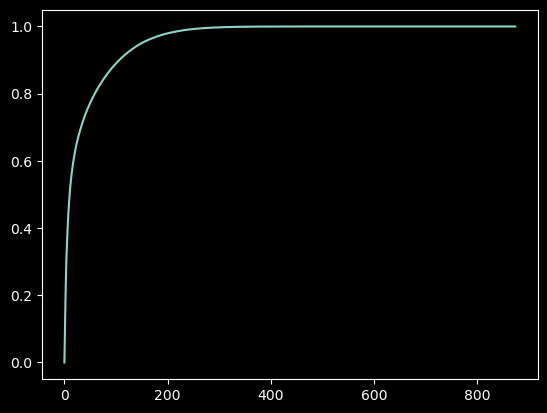

In [5]:
print(pca_pipeline[2].explained_variance_ratio_[:10])
explained_variance = np.cumsum(pca_pipeline[2].explained_variance_ratio_)
explained_variance = pd.Series(explained_variance, index=range(1, len(explained_variance)+1))
for _p in np.arange(.1, .95, .1):
    print('pcs needed to explain {}: {}'.format(_p.round(2), explained_variance[explained_variance <= _p].index.max()))
explained_variance = pd.Series([0] + explained_variance.values.tolist(), index=[0] + explained_variance.index.tolist())
explained_variance.plot()

Wow! A single PC captures about 10% of the variance among these companies. And we need only 10 PCs to capture ~50% of the variance.

# Analyzing Principal Components

## First PC

Let's look at that remarkable first PC and see if we can figure out what it means. Remember, it's just a new number -- a scale, a spectrum -- along which the companies can be spread out.

We'll look at the features which send a company to the left or right on this new scale, based on their sign.

In [7]:
df_loadings = pd.DataFrame(pca_pipeline[2].components_.T, index=cols_feat, columns=cols_pc)

def view_factor_loadings(pc_name, n_view = 10):
    global df_loadings
    series_loadings_view = df_loadings[pc_name].sort_values()
    cols_loading_low = series_loadings_view[:n_view].index.tolist()
    cols_loading_high = series_loadings_view[-n_view:].index.tolist()
    cols_loading = cols_loading_low + cols_loading_high
    display(df_loadings.loc[cols_loading, [pc_name]].style.background_gradient(cmap='coolwarm'))

In [8]:
view_factor_loadings('pc0', 12)
# df_loadings['pc0'].hist(bins=25)

,pc0
debtusd_over_assetsavg_ary5y_avg,-0.109095
debt_over_assetsavg_ary5y_avg,-0.109095
ebitusd_over_assetsavg_art_chg,-0.109095
ebit_over_assetsavg_art_chg,-0.109095
opinc_over_assetsavg_art_chg,-0.109095
netinc_over_assetsavg_art_chg,-0.109095
consolinc_over_assetsavg_art_chg,-0.109095
ebt_over_assetsavg_art_chg,-0.109094
opex_over_assetsavg_ary5y_avg,-0.109094
sgna_over_assetsavg_ary5y_avg,-0.109094


I see an interesting symmetry here:
- low end
    - higher debt, opex and sales cost norm
    - growing earnings
- high end
    - higher earnings norm
    - growing debt, opex and sales

My hypothesis: **`pc0` captures differences in asset efficiency, contrasting growth companies to more established, asset-efficient operations.**

Let's go see which industries/sectors are over-represented by each end of this new scale.

In [9]:
df_ticker_pca = df_pca.merge(df_tickers, how='inner', on='ticker')

def show_top_sector_industry(pc_name, col1, col2='', n_show=5, quantile=.05):
    global df_ticker_pca

    # Low end of PC
    sel = df_ticker_pca[pc_name] < df_ticker_pca[pc_name].quantile(quantile)
    if col2:
        base_dist = df_ticker_pca[[col1, col2, 'ticker']].groupby([col1, col2]).count()
        select_dist = df_ticker_pca.loc[sel, [col1, col2, 'ticker']].groupby([col1, col2]).count()
    else:
        base_dist = df_ticker_pca[[col1, 'ticker']].groupby(col1).count()
        select_dist = df_ticker_pca.loc[sel, [col1, 'ticker']].groupby(col1).count()
    base_dist = 100 * base_dist / base_dist.sum()
    base_dist.columns = ['base (%)']
    select_dist = 100 * select_dist / select_dist.sum()
    select_dist.columns = ['low (%)']
    dist = pd.concat([base_dist, select_dist], axis=1)
    dist['Δ (%)'] = dist['low (%)'] - dist['base (%)']
    dist = dist.sort_values('Δ (%)', ascending=False)
    display(dist.head(n_show).style.background_gradient(cmap='coolwarm'))
    
    # High end of PC
    sel = df_ticker_pca[pc_name] < df_ticker_pca[pc_name].quantile(1 - quantile)
    if col2:
        base_dist = df_ticker_pca[[col1, col2, 'ticker']].groupby([col1, col2]).count()
        select_dist = df_ticker_pca.loc[sel, [col1, col2, 'ticker']].groupby([col1, col2]).count()
    else:
        base_dist = df_ticker_pca[[col1, 'ticker']].groupby(col1).count()
        select_dist = df_ticker_pca.loc[sel, [col1, 'ticker']].groupby(col1).count()
    base_dist = 100 * base_dist / base_dist.sum()
    base_dist.columns = ['base (%)']
    select_dist = 100 * select_dist / select_dist.sum()
    select_dist.columns = ['high (%)']
    dist = pd.concat([base_dist, select_dist], axis=1)
    dist['Δ (%)'] = dist['high (%)'] - dist['base (%)']
    dist = dist.sort_values('Δ (%)', ascending=False)
    display(dist.head(n_show).style.background_gradient(cmap='coolwarm'))

In [10]:
for c in ['sector', 'industry', 'sicsector', 'sicindustry', 'famaindustry']:
    print(c, len(set(df_tickers[c])))

sector 12
industry 152
sicsector 10
sicindustry 437
famaindustry 49


In [22]:
show_top_sector_industry('pc0', 'sicindustry')

,base (%),low (%),Δ (%)
sicindustry,,,
Pharmaceutical Preparations,5.165894,36.333973,31.168079
Biological Products (No Disgnostic Substances),1.517969,10.976754,9.458785
Surgical & Medical Instruments & Apparatus,1.824656,4.966944,3.142288
In Vitro & In Vivo Diagnostic Substances,0.503857,2.791640,2.287783
Electromedical & Electrotherapeutic Apparatus,0.734725,2.360845,1.626120


,base (%),high (%),Δ (%)
sicindustry,,,
State Commercial Banks,5.828746,6.135422,0.306676
Pharmaceutical Preparations,5.165894,5.332953,0.167059
National Commercial Banks,3.390291,3.552907,0.162616
Real Estate Investment Trusts,4.537059,4.672929,0.135869
Services-Prepackaged Software,2.824265,2.937783,0.113517


Odd that pharma is on both ends of this one. Is there some split in that industry between established and research perhaps? On the other hand, the heavier relationship between pc0 and industry is on the lower end of this scale, where everything appears to be medical!

What big-name companies are currently on each end?

In [27]:
pc_view = 'pc0'
sel_current = df_pca.date == df_pca.date.max()
sel_pc_slice_neg = df_pca[pc_view] <= df_pca[pc_view].quantile(.05)
tickers_neg = df_pca[sel_current & sel_pc_slice_neg].sort_values('mcap_daily_scaled_log', ascending=False).head(10).ticker
print('low end:')
display(df_tickers[df_tickers.ticker.isin(tickers_neg)])

print('---------------------------------------')
sel_pc_slice_pos = df_pca[pc_view] >= df_pca[pc_view].quantile(.95)
tickers_pos = df_pca[sel_current & sel_pc_slice_pos].sort_values('mcap_daily_scaled_log', ascending=False).head(10).ticker
print('high end:')
display(df_tickers[df_tickers.ticker.isin(tickers_pos)])

low end:


,ticker,name,sicsector,sicindustry,famaindustry,sector,industry
452,DAL,DELTA AIR LINES INC,Transportation Communications Electric Gas And...,Air Transportation Scheduled,Transportation,Industrials,Airlines
2836,IBRX,IMMUNITYBIO INC,Manufacturing,Biological Products (No Disgnostic Substances),Pharmaceutical Products,Healthcare,Biotechnology
4495,F,FORD MOTOR CO,Manufacturing,Motor Vehicles & Passenger Car Bodies,Automobiles and Trucks,Consumer Cyclical,Auto Manufacturers
6164,CRNX,CRINETICS PHARMACEUTICALS INC,Manufacturing,Pharmaceutical Preparations,Pharmaceutical Products,Healthcare,Biotechnology
11297,W,WAYFAIR INC,Retail Trade,Retail-Catalog & Mail-Order Houses,Retail,Consumer Cyclical,Internet Retail
11492,APLS,APELLIS PHARMACEUTICALS INC,Manufacturing,Pharmaceutical Preparations,Pharmaceutical Products,Healthcare,Biotechnology
13366,AXSM,AXSOME THERAPEUTICS INC,Manufacturing,Pharmaceutical Preparations,Pharmaceutical Products,Healthcare,Biotechnology
13385,BBIO,BRIDGEBIO PHARMA INC,Manufacturing,Pharmaceutical Preparations,Pharmaceutical Products,Healthcare,Biotechnology
14113,ITCI,INTRA-CELLULAR THERAPIES INC,Manufacturing,Pharmaceutical Preparations,Pharmaceutical Products,Healthcare,Drug Manufacturers - Specialty & Generic
14270,MDGL,MADRIGAL PHARMACEUTICALS INC,Manufacturing,Pharmaceutical Preparations,Pharmaceutical Products,Healthcare,Biotechnology


---------------------------------------
high end:


,ticker,name,sicsector,sicindustry,famaindustry,sector,industry
1941,XOM,EXXON MOBIL CORP,Manufacturing,Petroleum Refining,Petroleum and Natural Gas,Energy,Oil & Gas Integrated
5778,AAPL,APPLE INC,Manufacturing,Electronic Computers,Computers,Technology,Consumer Electronics
6201,CVX,CHEVRON CORP,Manufacturing,Petroleum Refining,Petroleum and Natural Gas,Energy,Oil & Gas Integrated
7472,TXN,TEXAS INSTRUMENTS INC,Manufacturing,Semiconductors & Related Devices,Electronic Equipment,Technology,Semiconductors
7501,UNP,UNION PACIFIC CORP,Transportation Communications Electric Gas And...,Railroads Line-Haul Operating,Transportation,Industrials,Railroads
10265,GOOGL,ALPHABET INC,Services,Services-Computer Programming Data Processing ...,Business Services,Communication Services,Internet Content & Information
10568,MCD,MCDONALDS CORP,Retail Trade,Retail-Eating Places,Restaraunts Hotels Motels,Consumer Cyclical,Restaurants
10683,NEE,NEXTERA ENERGY INC,Transportation Communications Electric Gas And...,Electric Services,Utilities,Utilities,Utilities - Regulated Electric
12526,NVDA,NVIDIA CORP,Manufacturing,Semiconductors & Related Devices,Electronic Equipment,Technology,Semiconductors
14282,META,META PLATFORMS INC,Services,Services-Computer Programming Data Processing ...,Business Services,Communication Services,Internet Content & Information


Yeah we see the trend continuing with current market data: The low end of the `pc0` scale is heavy with pharma, while the other end is more diverse. Both extremes seem heavy in manufacturing, perhaps because the primary ratios involved are on an asset basis, and manufacturing is asset-intensive. To be honest, however, I don't understand everything I'm seeing here.

### A Speculation
And yet, if my general interpretation of `pc0` is correct, I would expect Apple and Amazon to have drifted upward toward efficiency and away from growth through time, right? Since they were both once growth tech as well?

<Axes: xlabel='date'>

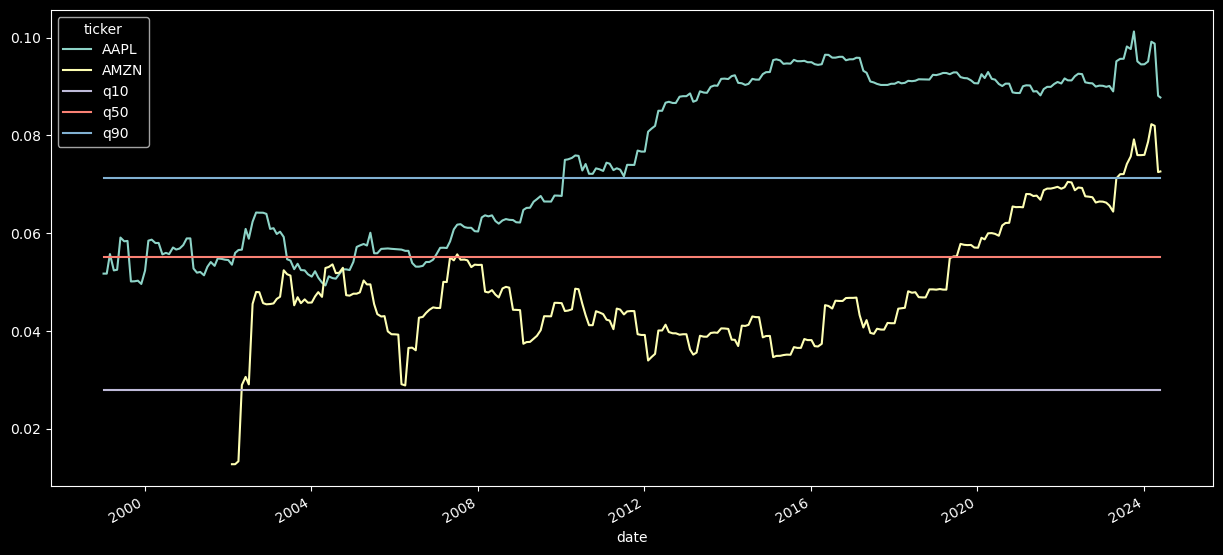

In [15]:
df_drift = df_pca.loc[df_pca.ticker.isin(['AAPL', 'AMZN']), ['ticker', 'date', 'pc0']]
df_drift = df_drift.pivot(columns='ticker', index='date', values='pc0')
df_drift[['q10', 'q50', 'q90']] = df_pca.pc0.quantile([.1, .5, .9]).values
df_drift.plot(figsize=(15, 7))

And indeed, we can see that Apple began its journey toward efficiency after the iPhone was released. I assume this was in part because of how much of their manufacturing was off-shored during the smart phone revolution. All those factories are on contractors' books instead of Apple's. The run up in efficiency could also be due to Tim Cook, an operations guy, taking over the company in this period.

I'm not really sure why Amazon flipped the switch in 2017-2018, as I know less of their history. But both companies seem to have achieved remarkable journeys -- from "growth" to "efficiency" if my interpretation is correct -- in just 3-4 years.

Note: The straight lines are the 10th percentile, 50th percentile (median) and 90th percentile on this scale *for all time*. So Apple has become an astonishing outlier on this scale.

---

Now I'd also expect fast food chains to be high in efficiency throughout their lifecycle. So let's look at McDonald's, Chipotle and Starbucks.

<Axes: xlabel='date'>

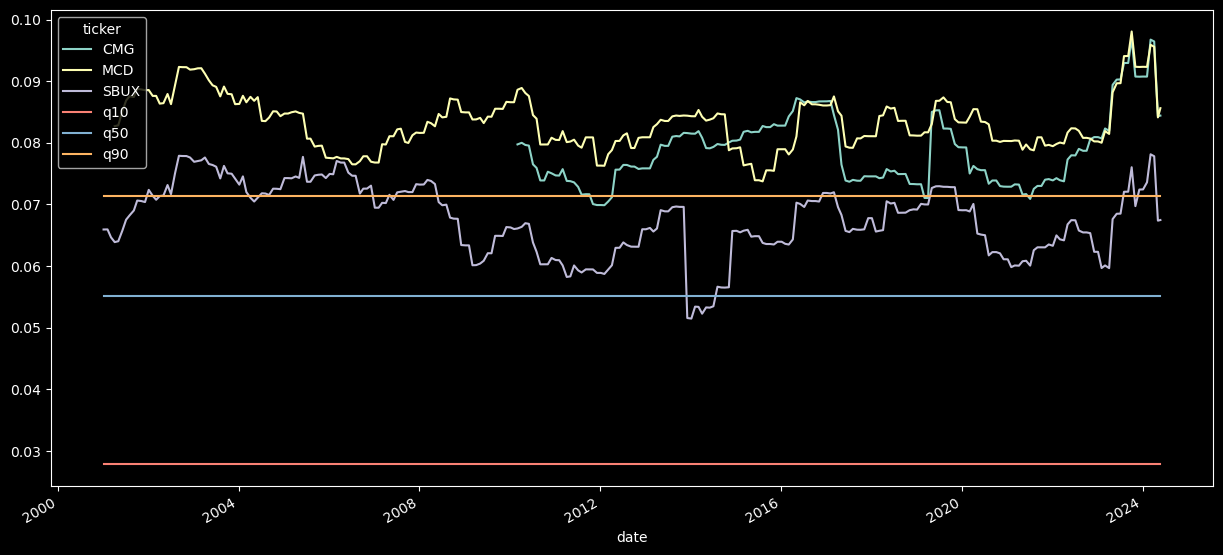

In [30]:
df_drift = df_pca.loc[df_pca.ticker.isin(['MCD', 'CMG', 'SBUX']), ['ticker', 'date', 'pc0']]
df_drift = df_drift.pivot(columns='ticker', index='date', values='pc0')
df_drift[['q10', 'q50', 'q90']] = df_pca.pc0.quantile([.1, .5, .9]).values
df_drift.plot(figsize=(15, 7))

Yes, but less-so for Starbucks. I have no idea why. Quite interesting though!

## Second PC

I'm going to run through a handful more of these with less discussion.

In [235]:
view_factor_loadings('pc1', 15)

,pc1
capex_over_fcf_art,-0.107128
capex_over_fcf_art_chg,-0.107043
netincdis_over_fcf_art_chg,-0.106270
netincdis_over_fcf_art,-0.106264
ncfdebt_over_fcf_art,-0.105004
ncfdebt_over_fcf_art_chg,-0.104934
retearn_over_fcf_art,-0.079788
ncff_over_fcf_art_chg,-0.078131
ncff_over_fcf_art,-0.078125
retearn_over_fcf_art_chg,-0.077250


In [41]:
for c in ['sector', 'industry', 'sicsector', 'sicindustry', 'famaindustry']:
    print(c, len(set(df_tickers[c])))

sector 12
industry 152
sicsector 10
sicindustry 437
famaindustry 49


In [226]:
show_top_sector_industry('pc1', 'sector', 'industry', 10)

So PC1 appears to measure the capital intensity of a business -- whether money must be continuously pumped into infrastructure. The opposite end seems to represent service orientation. Very interesting!

## Third PC

In [234]:
view_factor_loadings('pc2', 15)

,pc2
debtusd_over_fcf_ary5y_avg,-0.114700
debt_over_fcf_ary5y_avg,-0.114699
ppnenet_over_fcf_ary5y_avg,-0.114696
intexp_over_fcf_ary5y_avg,-0.114689
invcapavg_over_fcf_ary5y_avg,-0.114684
invcap_over_fcf_ary5y_avg,-0.114676
equityusd_over_fcf_ary5y_avg,-0.114676
equity_over_fcf_ary5y_avg,-0.114676
equityavg_over_fcf_ary5y_avg,-0.114674
cashnequsd_over_fcf_ary5y_avg,-0.114647


This is actually about free cashflow stability. FCF is the common element in all these ratios, with one end (upper) measuring instability of cashflows compared to many major figures.

## Fourth PC

In [236]:
view_factor_loadings('pc3', 15)

,pc3
ncfo_over_revenue_ary5y_avg,-0.128449
opinc_over_revenue_ary5y_avg,-0.128436
ebit_over_revenue_ary5y_avg,-0.125439
ebitusd_over_revenue_ary5y_avg,-0.125439
ebitda_over_revenue_ary5y_avg,-0.125136
ebitdausd_over_revenue_ary5y_avg,-0.125136
consolinc_over_revenue_ary5y_avg,-0.122525
netinc_over_revenue_ary5y_avg,-0.122321
ebt_over_revenue_ary5y_avg,-0.122208
netinccmnusd_over_revenue_ary5y_avg,-0.121169


Revenue stability.

## Fifth PC

In [237]:
view_factor_loadings('pc4', 15)

,pc4
tangibles_over_assetsavg_art_chg,-0.164032
assets_over_assetsavg_art_chg,-0.164030
assetsc_over_assetsavg_art_chg,-0.163996
cashnequsd_over_assetsavg_art_chg,-0.163982
cashneq_over_assetsavg_art_chg,-0.163982
receivables_over_assetsavg_art_chg,-0.163949
revenueusd_over_assetsavg_art_chg,-0.163751
cor_over_assetsavg_art_chg,-0.163670
gp_over_assetsavg_art_chg,-0.162436
ncfcommon_over_assetsavg_art_chg,-0.162199


Asset stability.

## Sixth PC

In [239]:
view_factor_loadings('pc5', 15)

,pc5
opex_over_revenue_art,-0.137363
tangibles_over_revenue_art,-0.135986
ncff_over_revenue_art,-0.134797
sbcomp_over_revenue_art,-0.133673
sgna_over_revenue_art,-0.129256
payables_over_revenue_art,-0.127915
liabilities_over_revenue_art,-0.126262
liabilitiesc_over_revenue_art,-0.120583
assets_over_revenue_art,-0.118804
opex_over_revenue_art_chg,-0.116386


This is recent (TTM) profitability, pure and simple -- where the revenue goes. To keeping the business runing (low end) or to income/earnings (upper end).

Important note: The three "stability" PCs are clearly present due to a bias I introduced, as they represent the stability of denominators *I chose* for my ratios. To get a more general set of PCs, we'd probably want to measure *all currency ratios*. With 70 such variables and computing TTM, 5Y_AVG and TTM - 5Y_AVG, that would yield 3*(70 choose 2) = 7245 features! I wanted something faster and simpler for these demos.

# Checking Our Intuition

Here's a summary of what we've analyzed so far:

| Principal Component | Low End                            | High End                           | "Good" End (Guess)         |
|---------------------|------------------------------------|------------------------------------| -------------------------- |
| pc0                 | Growth pattern                     | Established business               | high                       |
| pc1                 | Capital-intensive                  | Capital-efficient                  | high                       |
| pc2                 | Cashflow-stable                    | Cashflow-unstable                  | low                        |
| pc3                 | Revenue-stable                     | Revenue-unstable                   | low                        |
| pc4                 | Asset-stable                       | Asset-unstable                     | low                        |
| pc5                 | Unprofitable                       | Profitable                         | high                       |

Let's see if we can find stocks in the "better" upper/lower third and see what their stock-wise excess return profile is.

In [92]:
sel_pc_custom = df_pca.pc0 > df_pca.pc0.quantile(.66)
sel_pc_custom = sel_pc_custom & (df_pca.pc1 > df_pca.pc1.quantile(.66))
sel_pc_custom = sel_pc_custom & (df_pca.pc2 < df_pca.pc2.quantile(.33))
sel_pc_custom = sel_pc_custom & (df_pca.pc3 < df_pca.pc3.quantile(.33))
sel_pc_custom = sel_pc_custom & (df_pca.pc4 < df_pca.pc4.quantile(.33))
sel_pc_custom = sel_pc_custom & (df_pca.pc5 > df_pca.pc5.quantile(.66))
print('stock-wise performance:')
print(df_pca.loc[sel_pc_custom, 'epc'].agg(['count', 'mean', 'median']))
print('\nday-wise performance:')
print(df_pca.loc[sel_pc_custom, ['date', 'epc']].groupby('date').mean().agg(['count', 'mean', 'median']).epc)

stock-wise performance:
count    141.000
mean       0.016
median     0.001
Name: epc, dtype: float64

day-wise performance:
count    111.000
mean       0.014
median     0.001
Name: epc, dtype: float64


These "better" stocks outperformed by about 1.5%, nothing amazing.

Then again as I look over them, I've gotta ask: who cares about asset stability anyway? What if we don't filter for that?

In [94]:
sel_pc_custom = df_pca.pc0 > df_pca.pc0.quantile(.66)
sel_pc_custom = sel_pc_custom & (df_pca.pc1 > df_pca.pc1.quantile(.66))
sel_pc_custom = sel_pc_custom & (df_pca.pc2 < df_pca.pc2.quantile(.33))
sel_pc_custom = sel_pc_custom & (df_pca.pc3 < df_pca.pc3.quantile(.33))
# sel_pc_custom = sel_pc_custom & (df_pca.pc4 < df_pca.pc4.quantile(.33))
sel_pc_custom = sel_pc_custom & (df_pca.pc5 > df_pca.pc5.quantile(.66))
print('stock-wise performance:')
print(df_pca.loc[sel_pc_custom, 'epc'].agg(['count', 'mean', 'median']))
print('\nday-wise performance:')
print(df_pca.loc[sel_pc_custom, ['date', 'epc']].groupby('date').mean().agg(['count', 'mean', 'median']).epc)

stock-wise performance:
count    838.000
mean       0.077
median     0.025
Name: epc, dtype: float64

day-wise performance:
count    226.000
mean       0.054
median     0.025
Name: epc, dtype: float64


"Top" companies had a return 7.7% beyond the market on average, median 2.5%. Daily mean and median of 5.4% and 2.5%, respectively. Not bad.

Important note: This is a retrospective look through the entire historical dataset to make sense of what happened. You can't use this method for prediction in time, such as for future returns. That must happen *forward in time*. See [2_prediction.ipynb](./2_prediction.ipynb) for an example.

---

# Conclusion

## Human learning > machine learning

We've just transformed a pile of financial measurements into a profound lesson about deep patterns in the stock market. In other words, the machine taught *us* something!

There are many more techniques available for the ML-empowered investigator: other matrix methods like PCA, manifolds, autoencoders, feature networks, supervised methods to filter for feature relevancy. The key advantage is this: *These algorithms allow investigators to see in high dimensions.* We no longer need to guess what's relevant; we can instead measure tons of things then distill.

## Going beyond dashboards

While SQL is effective for blending and aligning data, and dashboards are great for automating visualizations, neither is an adequate analysis tool. We can display results with them, but we must first dig with better tools. For example, what if many factors need consideration? Dashboard plots display at most five variables at once (two axes plus marker size, shape, and color). And even that gets messy and difficult to interpret:

<img src="./images/scatter.png" alt="Messy Scatterplot" width="1000"/>


By contrast, an ML-capable analyst or data scientist who is motivated to *understand* your processes, rather than simply predict, can search broadly and figure out what's even worth investigating and sharing. They can put the depth back in the "deep dive". **I have personally used machine learning to find root causes in KPI drift, discover major issues in automated system behavior, and uncover a web store's core user segments.**

## Re-learning your business

I mean this in the nicest way possible: Many people do not understand their area of business as well as they think. That's not their fault; most companies are not equipped to *look deeply* with ML before trying to form a testable theory about what is happening. So while experimentation (A/B/n) remains important, starting with more comprehensive, data-informed theories can accelerate progress.

## Key takeaways
- Statistical testing (A/B/n) is important, but we need better theories to test.
- You probably don't understand your business as well as you think.
- Using data to learn about your business requires more than dashboards and SQL.
- The most important (and daunting) question in data is: *What am I missing?*
- Analysts must therefore over-measure, then distill using ML.